In [1]:
# what's a raymarshing

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pdb
plt.rcParams["figure.figsize"] = (6,6)

In [13]:
H = 100
W = 100
Z = 0

class DetectorSquare():
    def __init__(self, h=100, w=120, z=0):
        self.h, self.w = h, w
        self.r = float(self.w) / self.h
        self.x1, self.x2, self.y1, self.y2, self.z1, self.z2 = -1, 1, -1. / self.r + .25, 1. / self.r + .25, z, -z
        self.xes = np.linspace(self.x1, self.x2, self.w)
        self.yes = np.linspace(self.y1, self.y2, self.h)
        
class Ray():
    def __init__(self, location, vector, pixel):
        self.range = 0
        self.active = True
        self.energy = 0
        self.location = np.array(location)
        self.vector = np.array(vector)
        self.pixel = pixel

In [14]:
rays = []
origin = np.array([0, 0, 5])
detector = DetectorSquare(H,W,-5)

#create rays from ORIGIN to pixel at DetectorSquare
for i in range(W):
    for j in range(H):
        rays.append(Ray(location = [detector.xes[i],detector.yes[j],detector.z1],
                         vector = [detector.xes[i],detector.yes[j],detector.z1] - origin,
                         pixel = [i,j]))

In [15]:
length = lambda x: math.sqrt((x**2).sum())

def sphereSDF(p):  return length(p) - 0.6

def displace_point_along_vector(p0,vector,d):
    return p0 + vector/np.linalg.norm(vector)*d

In [16]:
while all([ray.active for ray in rays]):
    for q, ray in enumerate([x for x in rays if x.active]):
        save_displace = sphereSDF(ray.location)
        if (save_displace > 100): ray.active = False
        if save_displace < 0.001: 
            ray.energy = 1
            ray.active = False
        ray.location = displace_point_along_vector(ray.location, ray.vector, -save_displace)
        

In [17]:
energy_map = np.zeros((W,H))

In [18]:
for ray in rays:
    energy_map[ray.pixel[0],ray.pixel[1]]= ray.energy

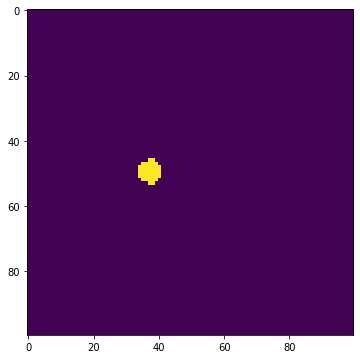

In [19]:
plt.imshow(energy_map)
plt.show()

In [99]:
# IMPLEMENT ANOTHER SDF HERE if you like

In [11]:
"""
MIT License
Copyright (c) 2017 Cyrille Rossant
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import numpy as np
import matplotlib.pyplot as plt

w = 400
h = 300

def normalize(x):
    x /= np.linalg.norm(x)
    return x

def intersect_plane(O, D, P, N):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # plane (P, N), or +inf if there is no intersection.
    # O and P are 3D points, D and N (normal) are normalized vectors.
    denom = np.dot(D, N)
    if np.abs(denom) < 1e-6:
        return np.inf
    d = np.dot(P - O, N) / denom
    if d < 0:
        return np.inf
    return d

def intersect_sphere(O, D, S, R):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # sphere (S, R), or +inf if there is no intersection.
    # O and S are 3D points, D (direction) is a normalized vector, R is a scalar.
    a = np.dot(D, D)
    OS = O - S
    b = 2 * np.dot(D, OS)
    c = np.dot(OS, OS) - R * R
    disc = b * b - 4 * a * c
    if disc > 0:
        distSqrt = np.sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return np.inf

def intersect(O, D, obj):
    if obj['type'] == 'plane':
        return intersect_plane(O, D, obj['position'], obj['normal'])
    elif obj['type'] == 'sphere':
        return intersect_sphere(O, D, obj['position'], obj['radius'])

def get_normal(obj, M):
    # Find normal.
    if obj['type'] == 'sphere':
        N = normalize(M - obj['position'])
    elif obj['type'] == 'plane':
        N = obj['normal']
    return N
    
def get_color(obj, M):
    color = obj['color']
    if not hasattr(color, '__len__'):
        color = color(M)
    return color

def trace_ray(rayO, rayD):
    # Find first point of intersection with the scene.
    t = np.inf
    for i, obj in enumerate(scene):
        t_obj = intersect(rayO, rayD, obj)
        if t_obj < t:
            t, obj_idx = t_obj, i
    # Return None if the ray does not intersect any object.
    if t == np.inf:
        return
    # Find the object.
    obj = scene[obj_idx]
    # Find the point of intersection on the object.
    M = rayO + rayD * t
    # Find properties of the object.
    N = get_normal(obj, M)
    color = get_color(obj, M)
    toL = normalize(L - M)
    toO = normalize(O - M)
    # Shadow: find if the point is shadowed or not.
    l = [intersect(M + N * .0001, toL, obj_sh) 
            for k, obj_sh in enumerate(scene) if k != obj_idx]
    if l and min(l) < np.inf:
        return
    # Start computing the color.
    col_ray = ambient
    # Lambert shading (diffuse).
    col_ray += obj.get('diffuse_c', diffuse_c) * max(np.dot(N, toL), 0) * color
    # Blinn-Phong shading (specular).
    col_ray += obj.get('specular_c', specular_c) * max(np.dot(N, normalize(toL + toO)), 0) ** specular_k * color_light
    return obj, M, N, col_ray

def add_sphere(position, radius, color):
    return dict(type='sphere', position=np.array(position), 
        radius=np.array(radius), color=np.array(color), reflection=.5)
    
def add_plane(position, normal):
    return dict(type='plane', position=np.array(position), 
        normal=np.array(normal),
        color=lambda M: (color_plane0 
            if (int(M[0] * 2) % 2) == (int(M[2] * 2) % 2) else color_plane1),
        diffuse_c=.75, specular_c=.5, reflection=.25)
    
# List of objects.
color_plane0 = 1. * np.ones(3)
color_plane1 = 0. * np.ones(3)
scene = [add_sphere([.75, .1, 1.], .6, [0., 0., 1.]),
         add_sphere([-.75, .1, 2.25], .6, [.5, .223, .5]),
         add_sphere([-2.75, .1, 3.5], .6, [1., .572, .184]),
         add_plane([0., -.5, 0.], [0., 1., 0.]),
    ]

# Light position and color.
L = np.array([5., 5., -10.])
color_light = np.ones(3)

# Default light and material parameters.
ambient = .05
diffuse_c = 1.
specular_c = 1.
specular_k = 50

depth_max = 5  # Maximum number of light reflections.
col = np.zeros(3)  # Current color.
O = np.array([0., 0.35, -1.])  # Camera.
Q = np.array([0., 0., 0.])  # Camera pointing to.
img = np.zeros((h, w, 3))

r = float(w) / h
# Screen coordinates: x0, y0, x1, y1.
S = (-1., -1. / r + .25, 1., 1. / r + .25)

# Loop through all pixels.
for i, x in enumerate(np.linspace(S[0], S[2], w)):
    if i % 10 == 0:
        print(i / float(w) * 100, "%")
    for j, y in enumerate(np.linspace(S[1], S[3], h)):
        col[:] = 0
        Q[:2] = (x, y)
        D = normalize(Q - O)
        depth = 0
        rayO, rayD = O, D
        reflection = 1.
        # Loop through initial and secondary rays.
        while depth < depth_max:
            traced = trace_ray(rayO, rayD)
            if not traced:
                break
            obj, M, N, col_ray = traced
            # Reflection: create a new ray.
            rayO, rayD = M + N * .0001, normalize(rayD - 2 * np.dot(rayD, N) * N)
            depth += 1
            col += reflection * col_ray
            reflection *= obj.get('reflection', 1.)
        img[h - j - 1, i, :] = np.clip(col, 0, 1)

plt.imsave('fig.png', img)

0.0 %
2.5 %
5.0 %
7.5 %
10.0 %
12.5 %
15.0 %
17.5 %
20.0 %
22.5 %
25.0 %
27.500000000000004 %
30.0 %
32.5 %
35.0 %
37.5 %
40.0 %
42.5 %
45.0 %
47.5 %
50.0 %
52.5 %
55.00000000000001 %
57.49999999999999 %
60.0 %
62.5 %
65.0 %
67.5 %
70.0 %
72.5 %
75.0 %
77.5 %
80.0 %
82.5 %
85.0 %
87.5 %
90.0 %
92.5 %
95.0 %
97.5 %
